In [1]:
%matplotlib inline

Download NCEP GFS 1 degree data file via OpenDAP

extract a number of fields at 300, 500 hPa, and surface

Calculate 500 hPa vorticity field

Plot the fields in 4 different figures

https://unidata.github.io/python-training/gallery/500hpa_absolute_vorticity_winds/ is a helfpul example

In [2]:
###########################################
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr

import metpy.calc as mpcalc
from metpy.units import units

from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo

from IPython.display import display,clear_output
import os
from datetime import datetime

###########################################

# Open the example netCDF data
#ds = xr.open_dataset(get_test_data('gfs_output.nc', False))

#ds = xr.open_dataset('/home/jovyan/GetGFS/gfs.20220223t00z.1p00.f012.nc')
#ds = xr.open_dataset('/home/jovyan/GetGFS/gfs.20220223t00z.0p25.f012.grb2.nc')

Open GFS forecasts using OpenDAP server directly. See 
https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap

In [3]:
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_1p00/gfs20220322/gfs_1p00_00z')

#ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs20220321/gfs_0p25_1hr_00z')
#ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_0p25/gfs20220310/gfs_0p25_00z')

ds

/opt/conda/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:         (time: 129, lev: 41, lat: 181, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2022-03-22 ... 2022-04-07
  * lev             (lev) float64 1e+03 975.0 950.0 925.0 ... 0.04 0.02 0.01
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon             (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Data variables: (12/215)
    absvprs         (time, lev, lat, lon) float32 ...
    no4lftxsfc      (time, lat, lon) float32 ...
    acpcpsfc        (time, lat, lon) float32 ...
    albdosfc        (time, lat, lon) float32 ...
    apcpsfc         (time, lat, lon) float32 ...
    capesfc         (time, lat, lon) float32 ...
    ...              ...
    vwshneg2pv      (time, lat, lon) float32 ...
    vwshtrop        (time, lat, lon) float32 ...
    watrsfc         (time, lat, lon) float32 ...
    weasdsfc        (time, lat, lon) float32 ...
    wiltsfc         (time, lat, lon) float32 ...
    var00212m       (time, lat, lon) float32 ...
Attributes:
    title:        GFS 1.0 deg starting from 00Z22mar2022, downloaded Mar 22 0...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Wed Mar 23 04:43:37 UTC 2022 : imported by GrADS Data Serve...

In [4]:
TIMEstring = np.datetime_as_string( ds['time'][0].values, unit='ms' )
TIMEstring

'2022-03-22T00:00:00.000'

In [5]:
latmin = 10.0
latmax = 90.0
lonmax = 360.0-50.0
lonmin = 360.0-140.0

lonmax = 360.0
lonmin = 0

lats = ds['lat'].sel(lat=slice(latmin,latmax))
lons = ds['lon'].sel(lon=slice(lonmin,lonmax))

d2r = np.pi/180.0
radius = 6378137.0 # meter

llats=len(lats)
llons=len(lons)

#print( llats, llons) 

# Combine 1D latitude and longitudes into a 2D grid of locations

lon_2d, lat_2d = np.meshgrid( lons, lats )

heights_300_mt = ds['hgtprs'].sel(lev=300,lat=slice(latmin,latmax),lon=slice(lonmin,lonmax))
u_300_mt = ds['ugrdprs'].sel(lev=300,lat=slice(latmin,latmax),lon=slice(lonmin,lonmax))
v_300_mt = ds['vgrdprs'].sel(lev=300,lat=slice(latmin,latmax),lon=slice(lonmin,lonmax))

heights_300_mt

<xarray.DataArray 'hgtprs' (time: 129, lat: 81, lon: 360)>
[3761640 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-03-22 2022-03-22T03:00:00 ... 2022-04-07
    lev      float64 300.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 86.0 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    long_name:  ** (1000 975 950 925 900.. 10 7 4 2 1) geopotential height [g...

In [6]:
# setup  projection for map plotting

###########################################

#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

#crs = ccrs.Mercator(central_longitude=-100.0)

crs = ccrs.NorthPolarStereo(central_longitude=-100.0)

###########################################

# Function used to create the map subplots
def plot_background(ax):
#    ax.set_extent([-125.0, -70.0, 20., 55.])
#    ax.set_extent([-130.0, -60.0, 20., 50.])
#    ax.set_extent([0.0, 360.0, 10., 90.])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

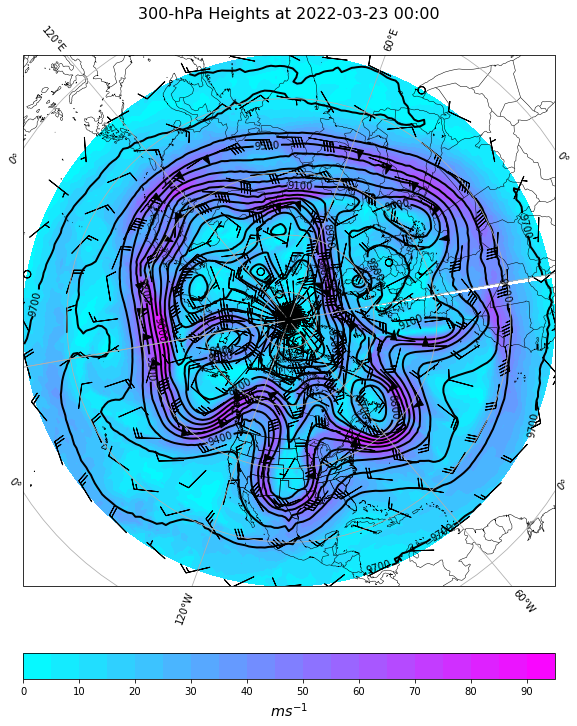

In [ ]:
# Create the figure and plot background on different axes

# https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), constrained_layout=True,
                          subplot_kw={'projection': crs})

date0 = np.datetime_as_string( ds['time'][0].values, unit='h' )
outdir='GFS_'+date0+'_pngs' # set = None, if you don't want save PNG images

if outdir and not os.path.exists(outdir): os.mkdir(outdir)
    
#for fcst_time in range(0,121):

#for fcst_time in range(0,129):
    
for fcst_time in range(0,129):

    TIMEstring = np.datetime_as_string( ds['time'][fcst_time].values, unit='m' )

    heights_300 = heights_300_mt[fcst_time,:,:].values
    
    u_300 = u_300_mt[fcst_time,:,:].values
    v_300 = v_300_mt[fcst_time,:,:].values
    winds_300 = np.sqrt( np.square(u_300) + np.square(v_300) )

    axarr.clear()
    
    plot_background(axarr)

# Upper left plot - 300-hPa winds and geopotential heights

#    cf1 = axarr.contourf(lon_2d, lat_2d, heights_300, levels=range(8000,9900,100), cmap='cool',
#                       transform=ccrs.PlateCarree())
    
    cf1 = axarr.contourf(lon_2d, lat_2d, winds_300, levels=range(0, 100, 5), cmap='cool',
                       transform=ccrs.PlateCarree())
        
    c1 = axarr.contour(lon_2d, lat_2d, heights_300, levels=range(8000,9900,100),colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
    axarr.clabel(c1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    
    if fcst_time == 0:
        cb1 = fig.colorbar(cf1, ax=axarr, location='bottom', shrink=1.0, fraction=0.05, pad=0.05)
        cb1.set_label('$m s^{-1}$', size='x-large')

# Set up a 2D slice to reduce the number of wind barbs plotted 
    wind_slice = (slice(None, None, 10), slice(None, None, 10))
    axarr.barbs(lon_2d[wind_slice], lat_2d[wind_slice],
         u_300[wind_slice], v_300[wind_slice],
         pivot='middle', color='black', transform=ccrs.PlateCarree())

    date = np.datetime_as_string( ds['time'][fcst_time].values, unit='m' )

    datestring = date[0:10]+' '+date[11:16]
    
# write the correct time in the title according to TIMEString

# Create a clean datetime object for plotting based on time of Geopotential heights
#vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')
#plt.title('Valid Time: {}'.format(vtime), loc='right')
# fig.suptitle(ds['time'][0].dt.strftime('%d %B %Y %H:%MZ').values, fontsize=24)

#    axarr.set_title('300-hPa Heights at '+datestring, fontsize=16)
    
    plt.title('300-hPa Heights at '+datestring, fontsize=16, loc='center')
    
    clear_output(wait=True)
    display(fig)
    
    if outdir: 
        pngname = outdir+'/GFS_Forecasts_'+date[0:13]+date[14:16]+'.png' 
        plt.savefig(pngname, dpi=72, color='red',facecolor='w', edgecolor='w', orientation='portrait',bbox_inches = 'tight')

clear_output()

## Animating your PNGs for the web

You can make an animation of your PNG, that can be viewed inside a web brower therefore published on the web.  Use [this code](https://code.activestate.com/recipes/580675-makes-html-with-javascript-to-animate-a-sequence-o). Download the python file and name it `janim.py`. You then use it by `import janim` as a module and use the function `makeanim` to construct the html file with embedded java script for web animation, as shown below.

In [ ]:
from janim import makeanim
import glob

In [ ]:
pngs = glob.glob(outdir+'/*.png') # the * matches anything
pngs.sort()


In [ ]:
makeanim(pngs,outfile="GFS_Forecasts"+date0+".html",sortOrder=True,
         ctlOnSide=True,titlestring="Animation of GFS Forecasts")